# Cohabit & marriage impact analysis - Non-ML based causal impact analysis

## Notebook objective
   * Conduct causal impact analysis using non-ML methods. 
   * The decided estimand is as follows: 
      * __In US national longitudinal survey (NLS) 97 respondents, what is the <span style="color:green"> probability/odds difference to scoring 8 or higher (i.e. sig. chance in having depression)</span> in the 2021 survey between the respondents that are married VS never married at the time of the survey?__


## Results summary
   * At a high level, __getting married will decrease the odds of scoring 8 or higher in CES-D7 by 40~60%__ (with variation based on different methods of estimation)
   * However, __when looking at probability difference, it is only 3~5%__
      * As a reference, we currently have ~10% responders with CESD-D7 scoring higher than 8
   * Following techniques were tested: logistic regression, propensity score matching, and inverse probability weighing was tested with different variables
   * _This is a just a notebook summary and not a project summary. In real world settings information needs to be organized differently based on the audience_


## Notes
   * __Data assumptions:__
      * SUTVA - We assume there's no spillover effect, and marriage "treatment" is the same across people. The latter is fixed such that marriage = having legal notice, but the effect is hard to justify it is equal among everyone. Nevertheless, we will assume so. 
   * List of responders is not completely random, as the sampling is done in two methods, listed below: 
      * A cross-sectional sample of 6,748 respondents designed to be representative of people living in the United States during the initial survey round and born between January 1, 1980, and December 31, 1984. For more information on representativeness of sample, see NLSY97 Technical Sampling Report (2000).
      * A supplemental sample of 2,236 respondents designed to oversample Hispanic/Latino and black people living in the United States during the initial survey round and born during the same period as the cross-sectional sample.
   * This is using logitudinal data however it's not really a panel data analysis since we are not comparing two points in time (as data is not available)
   * We will mainly use the 2019 data as it's pre-COVID, but may look at 2021 data for comparison
   * To reduce dependency between rounds (i.e. need to run previous rounds prior to running next round), some code may be redundant between rounds
   * At some point PCA can be used but is not being done here as I have not really studied PCA yet. 


## Imports

In [6]:
import pandas as pd
from io import StringIO
import re
from itables import init_notebook_mode
from itables import show

import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
from sklearn.neighbors import NearestNeighbors

from imblearn.under_sampling import RandomUnderSampler

import pickle

## Data preprocess

In [8]:
target_year = 2019
target_outcome = 'CESD_above_8'
target_treatment = 'married_vs_never_married'

In [9]:
def better_colnames(df, from_col: str, to_cols: list[str]  = ['Description','Year']):
    ''' Helper function to rename the columns in the (NLS data) df into something readable/helpful, based on data in codebook_df
    '''
    #Create dataframe with Ref column and the desired new column names based on input
    col_mapping = pd.concat([codebook_df[from_col],codebook_df[to_cols[0]].str.cat(codebook_df[to_cols[1:]],sep='_')],axis=1)    
    col_mapping.columns.values[1] = '_'.join(to_cols)
    #Convert the mapping dataframe to dictionary and rename columns
    return(df.rename(columns = col_mapping.set_index(from_col).squeeze().to_dict()))

In [10]:
tidy_df= pd.read_pickle('temp/tidy_df.pkl')
main_df= pd.read_pickle('temp/main_df.pkl')
codebook_df= pd.read_pickle('temp/codebook_df.pkl')
mental_health_df= pd.read_pickle('temp/mental_health_df.pkl')
codebook_df= pd.read_pickle('temp/codebook_df.pkl')
cohab_mhealth_df = pd.read_pickle('temp/cohab_mhealth_df.pkl')
source_df = pd.read_pickle('temp/source_df.pkl')
partner_df = pd.read_pickle('temp/partner_df.pkl')
marriage_stats_df = pd.read_pickle('temp/marriage_stats_df.pkl')
interview_df = pd.read_pickle('temp/interview_df.pkl')


In [11]:
#Model data creation

tidy_df_cols = {
    'uid': 'uid',
    'sex': 'sex',
    'age_1996': 'age_1996',
    'hispanic': 'hispanic',
    'race': 'race',
    'CV_URBAN_RURAL': 'urban',
    'CV_HH_SIZE': 'household_size',
    'CV_INCOME_FAMILY': 'household_income',
    'CV_HH_POV_RATIO': 'pov_ratio',
    'YHEA_1005': 'limited_work_kind',
    'YHEA_1006': 'limited_work_amt',
    'BIOADOPTCHILD_ADOPTED.01': 'child_1_adopted', #This can also tell if respondent has a child
    
}
source_df_cols = {
    'S1235200': 'asthma_2002',
    'S1235201': 'heart_2002',
    'S1235202': 'anemia_2002',
    'S1235203': 'diabetes_2002',
    'S1235204': 'cancer_2002',
    'S1235205': 'epilepsy_2002',
    'S1235206': 'hiv_aids_2002',
    'S1235207': 'std_2002',
    'S1235208': 'chronic_other_2002',
    'Z9083900': 'highest_degree',
    'R0534000': 'nonresp_parent_in_HH',
    'R1204500': 'hh_income_1997',
    'R0689000': 'pct_college_by_30',
    'R2182500': 'date_male_1998',
    'R2182000': 'date_female_1998',    
    'R0073000': 'num_days_homework'
}

#Initially add columns from tidy_df 
model_data_df = tidy_df.loc[tidy_df['Year'] == target_year,list(tidy_df_cols.keys()),]

#Add source_df columns
model_data_df = model_data_df.merge(source_df.loc[:,['uid'] + list(source_df_cols.keys())],on='uid')


#Add derived columns from previous work
cohab_mhealth_cols = ['uid','Rxx_CESD_SCORE_(x_ITEM)','married',target_outcome]
model_data_df = model_data_df.merge(cohab_mhealth_df.loc[cohab_mhealth_df['Year']==2019,cohab_mhealth_cols],on='uid')
model_data_df = model_data_df.rename(columns={'Rxx_CESD_SCORE_(x_ITEM)':'CESD'})


#converting the main treatments and outcome to int
#Since there are three states (Married, Not married but married before, Never married), we will create two separate columns 
model_data_df['CESD_above_8'] = model_data_df['CESD_above_8'].astype(int)
model_data_df['married_vs_not_married'] = (model_data_df['married'] == 'Yes').astype(int)
model_data_df['married_vs_never_married'] = (model_data_df['married'] == 'Yes').astype(int)
#For married VS never married, the "Married but married before" respondents will be marked as NaN
model_data_df.loc[model_data_df['married']=='No',['married_vs_never_married']] = np.nan

model_data_df.rename(columns=tidy_df_cols,inplace=True)
model_data_df.rename(columns=source_df_cols,inplace=True)

In [12]:
# Currently a lot of the columns are stored as sparse data. Some models choke as they don't handle such datatype. 
# Therefore, changing them to dense

def dense_columns(col):
    if (isinstance(col.dtype, pd.SparseDtype)): 
        return col.sparse.to_dense()
    else:
        return col
    
model_data_df = model_data_df.apply(dense_columns,axis=0)

In [13]:
#Create BMI columns. Since height and weight not mentioned every year, need to pull from last known

#Get index for last known weight and height 
last_known_wgt_idx = tidy_df.loc[(tidy_df['YSAQ_000B'].notnull()) & (tidy_df['YSAQ_000B'] > 0),:].groupby('uid')['YSAQ_000B'].idxmax()
last_known_hgt_idx = tidy_df.loc[(tidy_df['YSAQ_000A000001'].notnull()) & (tidy_df['YSAQ_000A000001'] > 0)
                                 & (tidy_df['YSAQ_000A000002'].notnull()) & (tidy_df['YSAQ_000A000002'] >= 0)
                                 ,:].groupby('uid')['YSAQ_000A000001'].idxmax()


#Using the values above, get bmi
bmi_df = tidy_df.loc[last_known_wgt_idx,['uid','YSAQ_000B']]
bmi_df = bmi_df.merge(tidy_df.loc[last_known_hgt_idx,['uid','YSAQ_000A000001','YSAQ_000A000002']],on='uid',how='left')
bmi_df['bmi'] = bmi_df['YSAQ_000B'] / ((bmi_df['YSAQ_000A000001'] * 12 + bmi_df['YSAQ_000A000002']) ** 2) * 703
bmi_df['bmi'] = bmi_df['bmi'].sparse.to_dense()

model_data_df.drop(['bmi','bmi_bin'],inplace=True,errors='ignore')
model_data_df = model_data_df.merge(bmi_df[['uid','bmi']], on='uid',how='left')

#Imputing bmi based on US average. Technically the average is different per male and female, but it's slight difference
# (29.1 VS 29.6) so just using the same value.
model_data_df['bmi'] = model_data_df['bmi'].fillna(29.4)

#There is one person with weight of 999. Assuming that's by error. Using average
model_data_df.loc[model_data_df['uid'] == 5707,'bmi'] = 29.4

#Create bin
model_data_df['bmi_bin'] = ''
model_data_df.loc[model_data_df['bmi'] < 18.5,'bmi_bin'] = 'under'
model_data_df.loc[model_data_df['bmi'].between(18.5, 25.0,inclusive='left'),'bmi_bin'] = 'normal'
model_data_df.loc[model_data_df['bmi'].between(25.0, 29.0,inclusive='left'),'bmi_bin'] = 'over'
model_data_df.loc[model_data_df['bmi'] > 29.0,'bmi_bin'] = 'obese'
model_data_df['bmi_bin'] = model_data_df['bmi_bin'].astype('category')

In [14]:
#Flipping urban variable values (0:rural 1:urban 2:unknown) to somewhat more ordinal (0:unknown 1:rural 2:urban)
model_data_df['urban'].fillna(0,inplace=True)
model_data_df.loc[model_data_df['urban'] < 0,'urban'] = 2
model_data_df['urban'] = model_data_df['urban'].map({0:1,1:2,2:0})

In [15]:
#Put any NaNs or negative values to zero
model_data_df['household_income'].fillna(0,inplace=True)
model_data_df.loc[model_data_df['household_income'] < 0, 'household_income'] = 0
#Log transform income
model_data_df['household_income_log'] = np.log(model_data_df['household_income'] + 1) 

model_data_df.loc[model_data_df['limited_work_kind'] < 0, 'limited_work_kind'] = 0
model_data_df.loc[model_data_df['limited_work_kind'] < 0, 'limited_work_kind'] = 0



model_data_df.loc[model_data_df['pov_ratio'] < 0, 'pov_ratio'] = 0

# Create a column for having a child or not. 
# One concern. This may not mean the child is still alive, which may negatively effect the mental health
model_data_df['has_child'] = (model_data_df['child_1_adopted'] < 0).astype(int)


In [16]:
model_data_df.loc[model_data_df['asthma_2002'] < 0, 'asthma_2002'] = 0
model_data_df.loc[model_data_df['heart_2002'] < 0, 'heart_2002'] = 0
model_data_df.loc[model_data_df['anemia_2002'] < 0, 'anemia_2002'] = 0
model_data_df.loc[model_data_df['diabetes_2002'] < 0, 'diabetes_2002'] = 0
model_data_df.loc[model_data_df['cancer_2002'] < 0, 'cancer_2002'] = 0
model_data_df.loc[model_data_df['epilepsy_2002'] < 0, 'epilepsy_2002'] = 0
model_data_df.loc[model_data_df['hiv_aids_2002'] < 0, 'hiv_aids_2002'] = 0
model_data_df.loc[model_data_df['std_2002'] < 0, 'std_2002'] = 0
model_data_df.loc[model_data_df['chronic_other_2002'] < 0, 'chronic_other_2002'] = 0

In [17]:
#For highest educational degree, there were few that refused to answer (-3). For them, setting as high school diploma (2)
model_data_df.loc[model_data_df['highest_degree'] < 0, 'highest_degree'] = 2

In [18]:
# Create log transform version of hh_income_1997. 
model_data_df['hh_income_1997_log'] = np.log(model_data_df['hh_income_1997'].map(lambda x: x if x > 0 else 0)+ 1) 

#Set negative values to NaNs
model_data_df.loc[model_data_df['pct_college_by_30'] < 0,'pct_college_by_30'] = np.nan
model_data_df.loc[model_data_df['num_days_homework'] < 0,'num_days_homework'] = np.nan


#combine date male and female 
model_data_df['date_1998'] = model_data_df.loc[:,['date_male_1998','date_female_1998']].max(axis=1)
model_data_df['date_1998'] = model_data_df['date_1998'].map(lambda x: x if x > 0 else 0)


In [19]:
#Get number of months married based on the interview year-month
temp_df = interview_df.loc[interview_df['Year']==target_year,:]
temp_df = temp_df.merge(marriage_stats_df,on='uid')
temp_df = temp_df.loc[(temp_df['marriage_start'] <= temp_df['interview_year-month']) & (temp_df['interview_year-month'] <= temp_df['marriage_end']) ,:]
temp_df['marriage_start_year'] = temp_df['marriage_start'].str[:4].astype(int)
temp_df['marriage_start_month'] = temp_df['marriage_start'].str[-2:].astype(int)
temp_df['years_married'] = ((temp_df['CV_INTERVIEW_DATE_Y'].astype(int) - temp_df['marriage_start_year'])) + ((temp_df['CV_INTERVIEW_DATE_M'].astype(int) - temp_df['marriage_start_month']) / 12.0)

model_data_df.drop('years_married',errors='ignore')
model_data_df = model_data_df.merge(temp_df[['uid','years_married']],on='uid',how='left')
model_data_df['years_married'].fillna(0,inplace=True)

model_data_df['years_married_log'] =  np.log(model_data_df['years_married'] + 1)

## Round 0 - Logistic regression w/ only treatment variable
   * Use logistic regression w/ married_vs_never_married only
   * Odds change: 0.44x, w/ p-value < 0.01

In [21]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)

In [22]:
formula = target_outcome +  ' ~ ' + target_treatment
print(formula)
# Fit the logistic regression model using GLM
model = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit()

# Print the summary of the model
print(model.summary())
print(f'Log odds increase when married: {math.exp(model.params[target_treatment])} ')
print(f'P-value: {model.pvalues[target_treatment]} ')


CESD_above_8 ~ married_vs_never_married
                 Generalized Linear Model Regression Results                  
Dep. Variable:           CESD_above_8   No. Observations:                 5838
Model:                            GLM   Df Residuals:                     5836
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1700.5
Date:                Wed, 14 Aug 2024   Deviance:                       3401.0
Time:                        09:42:40   Pearson chi2:                 5.84e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01333
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

## Round 1 - Logistic regression w/ few demographics
   * Use logistic regression w/ age, race-related & sex as additional explanatory variables
   * Additional assumptions
      * No unconfounding variables (HAHAHA...) 
      * Linearity of logit - We should check this but not checking for this round as the above assumption doesn't really hold anyways
   * __Result__
      * Odds change: 0.41x, w/ p-value < 0.01
      * There is significance btw male VS female. We will look at this later

In [24]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)

In [25]:
#formula creation

Xs_numerical = ['age_1996']
Xs_categorical = ['hispanic','sex','race']

formula = f'{target_outcome}  ~  {target_treatment} + ' + (' + '.join(Xs_numerical)) + ' + C(' + (') + C(').join(Xs_categorical) + ')'
print(formula)

CESD_above_8  ~  married_vs_never_married + age_1996 + C(hispanic) + C(sex) + C(race)


In [26]:
# Fit the logistic regression model using GLM
model = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit()

# Print the summary of the model
print(model.summary())
print(f'Log odds increase when married: {math.exp(model.params[target_treatment])} ')
print(f'P-value: {model.pvalues[target_treatment]} ')


                 Generalized Linear Model Regression Results                  
Dep. Variable:           CESD_above_8   No. Observations:                 5838
Model:                            GLM   Df Residuals:                     5825
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1677.1
Date:                Wed, 14 Aug 2024   Deviance:                       3354.3
Time:                        09:42:40   Pearson chi2:                 5.81e+03
No. Iterations:                    20   Pseudo R-squ. (CS):            0.02119
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


## Round 2 - Logistic regression w/ more fields
   * Use logistic regression w/ added fields:
      * BMI in bins (underweight, normal, over, obese)
      * Living in urban or rural place
      * Household income at survey year
      * <strike>POV ratio</strike>
      * Education level
      * Have child or not
      * Number of people in household
      * Chronic condition
      * Limited in kind<strike>/amount</strike> of work because of health
      * <strike>Length of marriage </strike>
   * Additional assumptions
      * No unconfounding variables (better than before with added variables, but still quite unsure)
      * Linearity of logit - Only checked non-logit linear correlation btw variables. No high r2s
   * __Result__
      * Odds change: 0.44x, w/ p-value < 0.01
      * If we look at ATE (average treatment effect), the difference in probability is ~ 3.8% 

In [63]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)

In [65]:
#formula creation

Xs_numerical = ['age_1996','household_size','household_income_log','has_child', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree']
Xs_categorical = ['hispanic','sex','race','bmi_bin','limited_work_kind',]

formula = f'{target_outcome}  ~  {target_treatment} + ' + (' + '.join(Xs_numerical)) + ' + C(' + (') + C(').join(Xs_categorical) + ')'
print(formula)

CESD_above_8  ~  married_vs_never_married + age_1996 + household_size + household_income_log + has_child + asthma_2002 + heart_2002 + anemia_2002 + diabetes_2002 + cancer_2002 + epilepsy_2002 + hiv_aids_2002 + std_2002 + chronic_other_2002 + urban + highest_degree + C(hispanic) + C(sex) + C(race) + C(bmi_bin) + C(limited_work_kind)


In [107]:
# Fit the logistic regression model using GLM
model = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit()
#model = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit_regularized)


# Print the summary of the model
print(model.summary())
print(f'Log odds difference when married: {math.exp(model.params[target_treatment])} ')
print(f'P-value: {model.pvalues[target_treatment]} ')

                 Generalized Linear Model Regression Results                  
Dep. Variable:           CESD_above_8   No. Observations:                 5838
Model:                            GLM   Df Residuals:                     5808
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1501.2
Date:                Wed, 14 Aug 2024   Deviance:                       3002.4
Time:                        15:06:43   Pearson chi2:                 5.80e+03
No. Iterations:                    20   Pseudo R-squ. (CS):            0.07844
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### Calculating the ATE
Instead of only looking at (log-)odds change, we will also calculate ATE. We will calculate by diffing the predicted outcome between treated (married) or not, and getting the average. This is basically s-learner

In [161]:
X0 = temp_model_data_df.assign(married_vs_never_married=0)
X0 = sm.add_constant(X0)
X1 = temp_model_data_df.assign(married_vs_never_married=1)
X1 = sm.add_constant(X1,has_constant='add')

o0 = model.predict(X0)
o1 = model.predict(X1)
print(f'Average probability for T = 1: {o0.mean():.4f}')
print(f'Average probability for T = 0: {o1.mean():.4f}')
print(f'Diff: {(o1.mean()- o0.mean()):.4f}')


Average probability for T = 1: 0.1059
Average probability for T = 0: 0.0673
Diff: -0.0385


In [148]:
# Since the treatment is binary, the AME (Average marginal effect) should be pretty close to ATE. Looking at the output for reference. 
marginal_effect = model.get_margeff()
marginal_effect.summary_frame().loc[target_treatment].to_frame()

,married_vs_never_married
dy/dx,-0.038951
Std. Err.,0.008688
z,-4.483291
Pr(>|z|),0.000007
Conf. Int. Low,-0.055980
Cont. Int. Hi.,-0.021923


## Round 3 - Propensity score matching
  * Since this is observational data (from treatment i.e. marriage perspective), we will attempt to apply propensity score to balance the assignments. 
  * We will use logistic regression for matching
  * Steps: 
     1. Decide on variables 
     2. Fit logistic regression model 
     3. Match data (nearest neighbor) & see propensity score overlap and covariates balance 
     4. Get average treatment effects
  * *Result*
     * Odds change: 0.59x
     * However there are a lot (~10%) of data points w/ propensity score of 0. This may mean we don't have enough variables for better scoring. Either way

### Variable selection
In addition to basic demographics that were used before, try to see if there are other variables
__Criteria__
   * Confounding variables
   * Pre-treatment variables
   * Not instrumental
   * (No peeking for balance)


   

In [33]:
# Checking to see which survey year data we can use (Total is ~8300)
# Based on below output, we will assume we can data from survey 1998 or less, since the # of people married is still low

print("# of people married by year:")
cohab_mhealth_df['First_marriage_year'].value_counts().sort_index().cumsum().head()

# of people married by year:


1996.0      2
1997.0     27
1998.0     79
1999.0    204
2000.0    429
Name: First_marriage_year, dtype: int64

In [34]:
# Look for additional variables that can be used for propensity scoring (but not for instrumental)
# Get all columns from particular year, and set negative values to NaNs
temp_df = tidy_df.loc[tidy_df['Year'] == 1997,:].select_dtypes(exclude=['object','category'])
temp_df = temp_df.apply(dense_columns,axis=0)
temp_df = temp_df.applymap(lambda x: np.nan if x < 0 else x)

#Get needed treatment + outcome data and merge with previous df
temp2_df = cohab_mhealth_df.loc[cohab_mhealth_df['Year'] == target_year,['uid','Ever_cohabitted','CESD_above_8','married']].drop_duplicates()
temp_df = temp_df.merge(temp2_df,on='uid')

#Create same married flags in the same df
temp_df['married_vs_not_married'] = (temp_df['married'] == 'Yes').astype(int)
temp_df['married_vs_never_married'] = (temp_df['married'] == 'Yes').astype(int)
#For married VS never married, the "Married but married before" respondents will be marked as NaN
temp_df.loc[temp_df['married']=='No',['married_vs_never_married']] = np.nan

#Create correlation dataframe. Not using pearson as target (both treatment and outcome) is binomial
corr_df = temp_df.corrwith(temp_df['married_vs_never_married'],method='kendall').to_frame(name='corr').reset_index(names='name')
#Calculate % of nans 
temp3_df = (1 - temp_df.count() / temp_df.shape[0]).to_frame(name='nans').reset_index(names='name')
corr_df = corr_df.merge(temp3_df,on='name')

#Get descriptions from codebook
corr_df = corr_df.merge(codebook_df[['Modified_Question','Modified_Description']].drop_duplicates(),left_on='name',right_on='Modified_Question',how='left')
corr_df.drop('Modified_Question',axis=1,inplace=True)

#Looking at list of 
show(corr_df.loc[corr_df['nans'] <= 0.8,:].sort_values(by='corr',ascending=False))

C:\Users\hiron\AppData\Local\Temp\ipykernel_1324\741386516.py:18: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = temp_df.corrwith(temp_df['married_vs_never_married'],method='kendall').to_frame(name='corr').reset_index(names='name')


__Results__ 
   * Just by looking at correlation (kendall), the correlation score is low (<0.2). However we will include a few based on score & data availability
      * YOUTH_NONR1INHH.01 - If non-responding biological parent live in the household 
      * CV_INCOME_GROSS_YR - Gross income of household
      * PC11_014 - Percent change respondent has college degree by some age (only answered by age >= 16)
      * YTIM_2300 - # of days spending homework a week (only answered by age <= 15
      * YSAQ_296 - # of dates with male
      * YSAQ_294 - # of dates with female

### Fit propensity model (logistic regression)

In [37]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)

In [38]:
#Since "Number of days doing HW" and "Percent going to college by 30" is mutually exclusive by age, we will create two 
# separate models. 

Xs_numerical = ['hh_income_1997_log','date_1998','num_days_homework']
Xs_categorical = ['hispanic','sex','race','nonresp_parent_in_HH']
formula = f'{target_treatment} ~ ' + (' + '.join(Xs_numerical)) + ' + C(' + (') + C(').join(Xs_categorical) + ')'
print("Model over 15: " + formula)
# Fit the logistic regression model using GLM
model_over_15 = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit()
result1 = model_over_15.predict(temp_model_data_df[Xs_numerical+Xs_categorical])


#formula creation
Xs_numerical = ['hh_income_1997_log','date_1998','pct_college_by_30']
Xs_categorical = ['hispanic','sex','race','nonresp_parent_in_HH']
formula = f'{target_treatment} ~ ' + (' + '.join(Xs_numerical)) + ' + C(' + (') + C(').join(Xs_categorical) + ')'
print("Model under 16: " + formula)
# Fit the logistic regression model using GLM
model_under_16 = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit()
result2 = model_under_16.predict(temp_model_data_df[Xs_numerical+Xs_categorical])



Model over 15: married_vs_never_married ~ hh_income_1997_log + date_1998 + num_days_homework + C(hispanic) + C(sex) + C(race) + C(nonresp_parent_in_HH)
Model under 16: married_vs_never_married ~ hh_income_1997_log + date_1998 + pct_college_by_30 + C(hispanic) + C(sex) + C(race) + C(nonresp_parent_in_HH)


### Match responders and check balance

In [40]:
#Put the two (mutually exclusive) p-scores into one and add to the model data df
temp_df = pd.DataFrame({'pscore1':result1, 'pscore2':result2})
temp_df.fillna(0,inplace=True)
temp_df['pscore'] = temp_df['pscore1'] +temp_df['pscore2']

temp_model_data_df.drop('pscore',axis=1,errors='ignore',inplace=True)
temp_model_data_df = pd.concat([temp_model_data_df,temp_df[['pscore']]],axis=1)

<AxesSubplot: xlabel='pscore', ylabel='Count'>

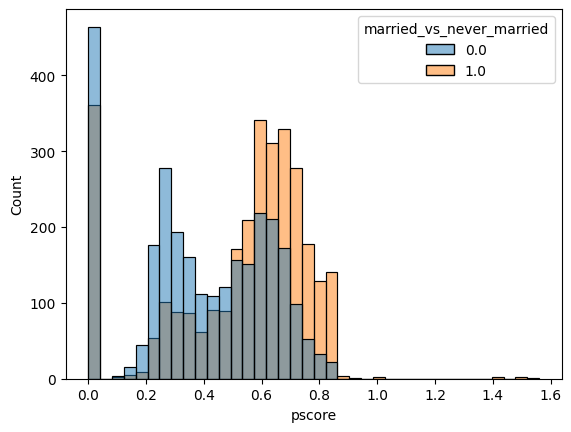

In [41]:
#Check propensity score overlap between treated (married) and untreated
sns.histplot(data=temp_model_data_df, x='pscore', hue=target_treatment) 

In [42]:
#Use nearest neighbor to get matched indices and create new dataframe for it. 

T = temp_model_data_df[target_treatment]

treated = temp_model_data_df[temp_model_data_df[target_treatment] == 1]
control = temp_model_data_df[temp_model_data_df[target_treatment] == 0]

# Fit the Nearest Neighbors model on the control group's propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['pscore']])

# Find the nearest neighbors in the control group for each treated unit
distances, indices = nn.kneighbors(treated[['pscore']])

# Get the matched control indices
matched_control_indices = control.iloc[indices.flatten()].index

# Create a DataFrame with the matched pairs
matched_df = pd.concat([treated, temp_model_data_df.loc[matched_control_indices]])

show(matched_df.groupby(target_treatment).mean())


C:\Users\hiron\AppData\Local\Temp\ipykernel_1324\1006916421.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  show(matched_df.groupby(target_treatment).mean())


In [43]:
show(temp_model_data_df.groupby(target_treatment).mean())

C:\Users\hiron\AppData\Local\Temp\ipykernel_1324\863515322.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  show(temp_model_data_df.groupby(target_treatment).mean())


__Results__
   * There seems a good overlap between treated & untreated w/ propensity score, although there are a lot of 0 propensity scores which is concerning
   * The balance of covariates seems ok (was also checked for categorical variables) though there may not be a huge difference

### Get effect

In [167]:
# Calculate the mean outcome for the treated and matched control groups
treated_outcome = matched_df[matched_df[target_treatment] == 1][target_outcome].mean()
control_outcome = matched_df[matched_df[target_treatment] == 0][target_outcome].mean()

# Calculate the Average Treatment Effect (ATE)
ate = treated_outcome - control_outcome

print(f"Prob. of CESD > x for married: {treated_outcome:.4f}")
print(f"Prob. of CESD > x for never married: {control_outcome:.4f}")
print(f"Average Treatment Effect in prob.: {(treated_outcome - control_outcome):.4f}")
print('')

# Convert to odds to match with others
treated_outcome_odds = treated_outcome / (1 - treated_outcome)
control_outcome_odds = control_outcome / (1 - control_outcome)

                        
print(f"Odds for CESD > x for married: {treated_outcome_odds:.4f}")
print(f"Odds for CESD > x for never married: {control_outcome_odds:.4f}")
print(f"Effect in odds ratio): {(treated_outcome_odds / control_outcome_odds):.4f}")




Prob. of CESD > x for married: 0.0570
Prob. of CESD > x for never married: 0.1061
Average Treatment Effect in prob.: -0.0492

Odds for CESD > x for married: 0.0604
Odds for CESD > x for never married: 0.1188
Effect in odds ratio): 0.5089


## Round 4 - Inverse probability weighting
Use propensity score method from preious step to calculate average effect using IPW instead of PSM

__Big note: As IPW doesn't allow pscore of 0, we are discarding about 10% of users. This round is done just for reference only__

__Results__
   * Odds change: 0.61x

In [48]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)

In [49]:
#Since "Number of days doing HW" and "Percent going to college by 30" is mutually exclusive by age, we will create two 
# separate models. 

Xs_numerical = ['hh_income_1997_log','date_1998','num_days_homework']
Xs_categorical = ['hispanic','sex','race','nonresp_parent_in_HH']
formula = f'{target_treatment} ~ ' + (' + '.join(Xs_numerical)) + ' + C(' + (') + C(').join(Xs_categorical) + ')'
print("Model over 15: " + formula)
# Fit the logistic regression model using GLM
model_over_15 = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit()
result1 = model_over_15.predict(temp_model_data_df[Xs_numerical+Xs_categorical])


#formula creation
Xs_numerical = ['hh_income_1997_log','date_1998','pct_college_by_30']
Xs_categorical = ['hispanic','sex','race','nonresp_parent_in_HH']
formula = f'{target_treatment} ~ ' + (' + '.join(Xs_numerical)) + ' + C(' + (') + C(').join(Xs_categorical) + ')'
print("Model under 16: " + formula)
# Fit the logistic regression model using GLM
model_under_16 = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit()
result2 = model_under_16.predict(temp_model_data_df[Xs_numerical+Xs_categorical])

#Put the two (mutually exclusive) p-scores into one and add to the model data df
temp_df = pd.DataFrame({'pscore1':result1, 'pscore2':result2})
temp_df.fillna(0,inplace=True)
temp_df['pscore'] = temp_df['pscore1'] +temp_df['pscore2']

temp_model_data_df.drop('pscore',axis=1,errors='ignore',inplace=True)
temp_model_data_df = pd.concat([temp_model_data_df,temp_df[['pscore']]],axis=1)

Model over 15: married_vs_never_married ~ hh_income_1997_log + date_1998 + num_days_homework + C(hispanic) + C(sex) + C(race) + C(nonresp_parent_in_HH)
Model under 16: married_vs_never_married ~ hh_income_1997_log + date_1998 + pct_college_by_30 + C(hispanic) + C(sex) + C(race) + C(nonresp_parent_in_HH)


In [50]:
temp_model_data_df = temp_model_data_df.query('pscore!=0')

In [51]:
#Use nearest neighbor to get matched indices and create new dataframe for it. 

T = temp_model_data_df[target_treatment]

treated = temp_model_data_df[temp_model_data_df[target_treatment] == 1]
control = temp_model_data_df[temp_model_data_df[target_treatment] == 0]

# Fit the Nearest Neighbors model on the control group's propensity scores
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['pscore']])

# Find the nearest neighbors in the control group for each treated unit
distances, indices = nn.kneighbors(treated[['pscore']])

# Get the matched control indices
matched_control_indices = control.iloc[indices.flatten()].index

# Create a DataFrame with the matched pairs
matched_df = pd.concat([treated, temp_model_data_df.loc[matched_control_indices]])

In [52]:
# Calculate weights
matched_df['weight'] = np.where(matched_df[target_treatment] == 1, 1 / matched_df['pscore'], 1 / (1 - matched_df['pscore']))

# Calculate weighted outcomes
w_treated_outcome = np.sum(matched_df[matched_df[target_treatment] == 1]['weight'] * matched_df[matched_df[target_treatment] == 1][target_outcome]) / np.sum(matched_df[matched_df[target_treatment] == 1]['weight'])
w_control_outcome = np.sum(matched_df[matched_df[target_treatment] == 0]['weight'] * matched_df[matched_df[target_treatment] == 0][target_outcome]) / np.sum(matched_df[matched_df[target_treatment] == 0]['weight'])

# Calculate the ATE
ate = w_treated_outcome - w_control_outcome

print(f"Prob. of CESD > x for married: {w_treated_outcome:.4f}")
print(f"Prob. of CESD > x for never married: {w_control_outcome:.4f}")
print(f"Average Treatment Effect in prob. (Relative): {(w_treated_outcome / w_control_outcome):.4f}")
print('')

# Convert to odds to match with others
w_treated_outcome_odds = w_treated_outcome / (1 - w_treated_outcome)
w_control_outcome_odds = w_control_outcome / (1 - w_control_outcome)

                        
print(f"Odds for CESD > x for married: {w_treated_outcome_odds:.4f}")
print(f"Odds for CESD > x for never married: {w_control_outcome_odds:.4f}")
print(f"Average Treatment Effect in odds (Relative): {(w_treated_outcome_odds / w_control_outcome_odds):.4f}")



Prob. of CESD > x for married: 0.0582
Prob. of CESD > x for never married: 0.0966
Average Treatment Effect in prob. (Relative): 0.6027

Odds for CESD > x for married: 0.0618
Odds for CESD > x for never married: 0.1069
Average Treatment Effect in odds (Relative): 0.5782


## Round 5 - Logistic regression w/ balanced outcome sample via undersampling
Wanted to check how much the unbalance of outcome (CESD > 8 is about 1:10 ratio) is affecting the results from logistic regression. We use undersampling to balance the # of responders of CESD > 8 or not. 
   * __Result__
      * Odds change: 0.60x, w/ p-value < 0.01
      * In other words, not a large difference

In [54]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)

rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(temp_model_data_df, temp_model_data_df[target_outcome])

Xs_numerical = ['age_1996','household_size','household_income_log','has_child', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree']
Xs_categorical = ['hispanic','sex','race','bmi_bin','limited_work_kind',]

formula = f'{target_outcome}  ~  {target_treatment} + ' + (' + '.join(Xs_numerical)) + ' + C(' + (') + C(').join(Xs_categorical) + ')'
print(formula)



CESD_above_8  ~  married_vs_never_married + age_1996 + household_size + household_income_log + has_child + asthma_2002 + heart_2002 + anemia_2002 + diabetes_2002 + cancer_2002 + epilepsy_2002 + hiv_aids_2002 + std_2002 + chronic_other_2002 + urban + highest_degree + C(hispanic) + C(sex) + C(race) + C(bmi_bin) + C(limited_work_kind)


In [55]:
# Fit the logistic regression model using GLM
model = smf.glm(formula=formula, data=X_resampled, family=sm.families.Binomial()).fit()
#model = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit_regularized)


# Print the summary of the model
print(model.summary())
print(f'Log odds difference when married: {math.exp(model.params[target_treatment])} ')
print(f'P-value: {model.pvalues[target_treatment]} ')


                 Generalized Linear Model Regression Results                  
Dep. Variable:           CESD_above_8   No. Observations:                 1028
Model:                            GLM   Df Residuals:                      998
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -579.01
Date:                Wed, 14 Aug 2024   Deviance:                       1158.0
Time:                        09:42:46   Pearson chi2:                 1.03e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.2288
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


## backlog
   * Health_at_38_39
   * Substance use
   * Make length of marriage as the treatment instead of married VS not 
   * Use more later survey year qs for propensity score calculation
   * Instrumental variable? - Unable to find a variable (or set of them) that has high correlation w/ marriage (but low directly to outcome)

## Playground

In [58]:
temp_model_data_df = model_data_df.copy()
temp_model_data_df.dropna(axis=0,subset=target_treatment,inplace=True)

In [59]:
y_res.value_counts()

NameError: name 'y_res' is not defined

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(temp_model_data_df, temp_model_data_df[target_outcome])

#formula creation

Xs_numerical = ['age_1996','household_size','household_income_log','has_child', 
                'asthma_2002','heart_2002','anemia_2002','diabetes_2002','cancer_2002','epilepsy_2002',
                'hiv_aids_2002','std_2002','chronic_other_2002','urban', 'highest_degree']
Xs_categorical = ['hispanic','sex','race','bmi_bin','limited_work_kind',]

formula = f'{target_outcome}  ~  {target_treatment} + ' + (' + '.join(Xs_numerical)) + ' + C(' + (') + C(').join(Xs_categorical) + ')'
print(formula)

In [ ]:
# Fit the logistic regression model using GLM
model = smf.glm(formula=formula, data=X_res, family=sm.families.Binomial()).fit()
#model = smf.glm(formula=formula, data=temp_model_data_df, family=sm.families.Binomial()).fit_regularized)


# Print the summary of the model
print(model.summary())
print(f'Log odds difference when married: {math.exp(model.params[target_treatment])} ')
print(f'P-value: {model.pvalues[target_treatment]} ')


In [ ]:
show(tidy_df[['CV_URBAN_RURAL']])

In [ ]:
temp_df = cohab_mhealth_df.loc[:,['uid','Ever_cohabitted','CESD_above_8','married']].drop_duplicates()
temp_df.dropna(inplace=True)
temp_df = pd.pivot_table(temp_df,values='uid',index='Ever_cohabitted',columns='CESD_above_8',aggfunc='count')
temp_df / temp_df.sum()



In [ ]:
temp_df = cohab_mhealth_df.loc[cohab_mhealth_df['Year'] == 2021,['uid','Ever_cohabitted','CESD_above_8','married']].drop_duplicates()
temp2_df = tidy_df.loc[tidy_df['Year'] <= 2001].groupby('uid')[['YSAQ_291A','YSAQ_294A']].max().max(axis=1).to_frame()
temp2_df = temp2_df.applymap(lambda x: 0 if x < 0 else x)
temp_df = temp_df.merge(temp2_df,on='uid')
temp_df.rename(columns={0:'dated'},inplace=True)


temp_df.dropna(inplace=True)
temp_df = pd.pivot_table(temp_df,values='uid',index='dated',columns='married',aggfunc='count')
temp_df / temp_df.sum()

In [ ]:
# Look for variables that can be used for propensity scoring or as instrumental variable
# Get all columns from particular year, and set negative values to NaNs
temp_df = tidy_df.loc[tidy_df['Year'] == 1997,:].select_dtypes(exclude=['object','category'])
temp_df = temp_df.apply(dense_columns,axis=0)
temp_df = temp_df.applymap(lambda x: np.nan if x < 0 else x)

#Get needed treatment + outcome data and merge with previous df
temp2_df = cohab_mhealth_df.loc[cohab_mhealth_df['Year'] == target_year,['uid','Ever_cohabitted','CESD_above_8','married']].drop_duplicates()
temp_df = temp_df.merge(temp2_df,on='uid')

#Create same married flags in the same df
temp_df['married_vs_not_married'] = (temp_df['married'] == 'Yes').astype(int)
temp_df['married_vs_never_married'] = (temp_df['married'] == 'Yes').astype(int)
#For married VS never married, the "Married but married before" respondents will be marked as NaN
temp_df.loc[temp_df['married']=='No',['married_vs_never_married']] = np.nan

#Create correlation dataframe. Not using pearson as target (both treatment and outcome) is binomial
corr_df = temp_df.corrwith(temp_df['married_vs_never_married'],method='kendall').to_frame(name='corr').reset_index(names='name')
#Calculate % of nans 
temp3_df = (1 - temp_df.count() / temp_df.shape[0]).to_frame(name='nans').reset_index(names='name')
corr_df = corr_df.merge(temp3_df,on='name')

#Get descriptions from codebook
corr_df = corr_df.merge(codebook_df[['Modified_Question','Modified_Description']].drop_duplicates(),left_on='name',right_on='Modified_Question',how='left')
corr_df.drop('Modified_Question',axis=1,inplace=True)

#Looking at list of 
show(corr_df.loc[corr_df['nans'] < 0.7,:].sort_values(by='corr',ascending=False))

In [ ]:
show(temp_df.loc[:,['married_vs_never_married','YSAQ_364']].value_counts().to_frame().reset_index().pivot(index='married_vs_never_married',columns='YSAQ_364'))

In [ ]:
temp_df = cohab_mhealth_df.loc[:,['uid','Ever_cohabitted','CESD_above_8','married']].drop_duplicates()
temp_df.dropna(inplace=True)
temp_df.loc[:,['Ever_cohabitted','married']].value_counts(dropna=False)

R1210200 1997 married